# Reservoir computing as a model for motor learning
**Due**: 28 November

**Total marks**. **SWC**: 50 + 55 bonus, **Gatsby**: 80 + 25 bonus

**Pass mark**. **SWC**: 30, **Gatsby**: 55.

**Your name(s)**:  Timothy Sit

You will study a model of rate neurons, analysing its dynamics and implementing some learning procedures. The network is implemented for you in ```reservoir_net.py```. Please use Python 3 and do everything (code/plots/explanations) in this file. 

You should send the ```.ipynb``` as well as an ```.html``` version of it (file -> download as -> html) to roman.pogodin.17@ucl.ac.uk.

If you want to use equations, $\LaTeX$ works here.

#### Credits
The implementation of the reservoir is taken from https://github.com/romanpogodin/reservoir-attractor-learning (unpublished work).

## Model
The reservoir model is trying to mimic pattern generation in the cortex. Although the architecture is quite generic and only a small fraction of weights changes throughout learning, it can produce complicated patterns of activity. 

The ''reservoir'' consists of $N$ rate neurons (described by their membrane potentials $x_i$ and firing rates $r_i$). Reminiscent of the actual cortical connectivity, the density of recurrent connections is 10%. In the form of a differential equation,

$$
\newcommand{\b}[1]{\mathbf{#1}}
\begin{align}
\tau \dot{\b x}(t) \,&= -\b x(t) + g \b W_{rec}\b r(t) + \b W_{fb}\b z(t),\\
\b r(t) \,&= \tanh(\b x(t)) + \pmb \xi(t),\\
\b z(t) \,&= \b W_{ro}\b r(t).
\end{align}
$$

Here bold means vectors/matrices, and $\pmb \xi$ is the dynamical noise. Essentially, we have a pool of recurrent neurons (via $\b W_{rec}$) that projects to some readout units via $\b W_{ro}$ and receives feedback from those units via $\b W_{fb}$. Although $\b z$ might be multidimensional, we will only learn 1d functions. 

Scaling of the recurrent weights $g$ plays an important role -- it makes sure the network can produce a rich set of trajectories that can be further used in the readout units. We'll explore its influence soon.

Sometimes, reservoirs are called echo-state networks. It comes back to the original paper by H. Jaeger (2002) [echo-state] and usually implies that instead of $\b W_{fb}\b z(t)$ the reservoir reseives the ''true'' feedback $\b W_{fb}\b f(t)$. It usually leads to less stable solutions.

## Learning

In the vanilla setting, we're interested in learning only the readout weights $\b W_{ro}$. Ideally, the learning scheme should be biologically plausible, i.e.
1. use only local information to update each weight;
2. work in an unsupervised way (w/o direct access to $f(t)$);
3. admit delayed feedback/error signal;
4. admit delayed weight updates.

In this assignment, we concentrate only on the first point.

To measure the learning error, we run the network for some time without weight updates and then look at cross-correlation between the produced output and the target function. This is implemented for you. It is not the objective function optimised by the discussed learning rules, but as they all use different objectives, we use this unified measure of performance.

### References

**[FORCE]** Sussillo, D., & Abbott, L. F. (2009). Generating Coherent Patterns of Activity from Chaotic Neural Networks. Neuron

**[echo-state]** Jaeger, H. (2002). Adaptive Nonlinear System Identification with Echo State Networks. Advances in Neural Information Processing Systems (NIPS)

## How the code works

There are a few code samples in the very end of the notebook. They explain how to use the provided reservoir network's implementation and how to implement a learning rule in a compatible way. Please check it before doing the assignment.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# the network
import reservoir_net
# makes plots pretty
sns.set(style="darkgrid")
sns.set(font_scale=2)

Let's use this function to save some space:

In [2]:
def plot(y, x=None, xlabel='', ylabel='', title=''):
    plt.figure(figsize=(10, 5))
    
    if x is None:
        plt.plot(y)
    else:
        plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

## Target functions
We will test the performance on these two simple functions. The easy one has only a low frequency component, while the hard function also has a high frequency one. Both of them a periodic with the period of 1 second.

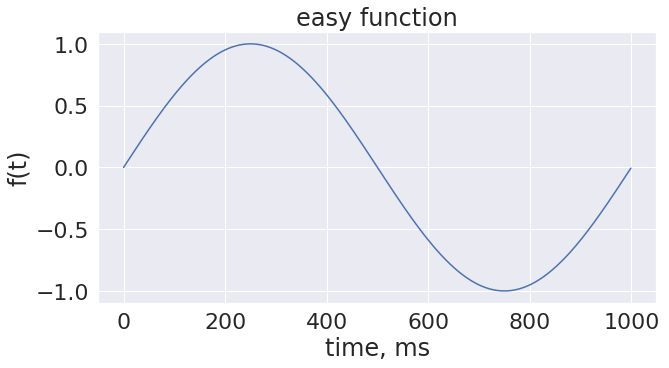

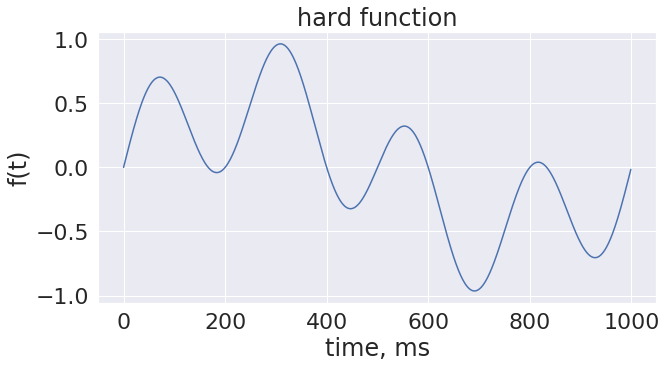

In [8]:
period = 1000  # ms

easy_target_values = np.sin(np.linspace(0, period - 1, period) / period * np.pi * 2)
hard_target_values = 0.5 * easy_target_values + \
    0.5 * np.sin(np.linspace(0, period - 1, period) / period * np.pi * 8)
# target_values = get_short_target(np.linspace(0, period - 1, period))

plot(easy_target_values, xlabel='time, ms', ylabel='f(t)', title='easy function')
plot(hard_target_values, xlabel='time, ms', ylabel='f(t)', title='hard function')

# Questions 

Use 500 neurons and default network parameters in every question, unless asked to change it.

### 1. Chaotic dynamics [20 points]

First, let's investigate how $g$ (```chaos_constant``` in the code) affects neural trajectories.

We know that the networks works in the chaotic regime when $g > 1$. For $g \geq 1.5$, it's called a strongly chaotic regime. 

1. [10 points] Explore the chaotic/non-chaotic regimes by experimentally estimating the variance of membrane potentials for different values of $g$. As the network starts from $\b x(0)=0$, what can you say about stability of this point for each $g$?
2. [5 points] Why such chaotic regime might be beneficial for learning?
3. [5 points] For $g>1$, what prevents the values of membrane potentials from going to $+\infty$?

You should pick a few neurons (```x[i]``` in ```to_record```) and at least 15 evenly spaced $g$ between $0.5$ and $2.0$. For each value of $g$, you will need a new instance of ```ReservoirInterface```. For a single $g$, call ```run_reservoir``` (as in the example below) multiple times to better estimate the variance.  As you're not trying to learn anything, number of training periods should be 0. Each call to ```run_reservoir``` will reset the network to ```x_init=0``` and run it for one **test** period.

### Solution:

 - The plan is to try out different values of `chaos_constant`, then calculate the variance of membrane potential

In [9]:
randseed = 42

n_neurons = 500
chaos_constant_list = np.linspace(start = 0.5, stop = 2, num = 15)
num_trial = 5 # run_resevoir multiple times to find a better estimat of the variance
training_periods = 0
test_frequency = 1  # test the function after each test_freq training trials 

# python will evaluate each entry, so make sure these variables are defined
# e.g. x[n_neurons] would result in an error, as x is defined for x[0], ..., x[n_neurons - 1]
to_record = ['z', 'x[0]']

# the default rule does nothing
learning_rule = reservoir_net.LearningRule()

# run simulation 
for chaos_constant in chaos_constant_list:
    # some variable to store the test_results
    test_results_list = list()
    # create some store of the variance value (to average(?) then over repeats)
    variance_list = list()
    # create ReservoirInterface
    simulator = reservoir_net.ReservoirInterface(learning_rule, period,
                                             randseed=randseed, chaos_constant=chaos_constant,
                                             n_reservoir_neurons=n_neurons)
    # may have to change randseed to get different values, to estimate variance
    for trial in np.arange(0, num_trial):
        # call run_reservoir, I think we are only interested in test_results
        train_results, test_results, correlation = simulator.run_reservoir(
    easy_target_values, training_periods, test_frequency, to_record) 
        test_results_list.append(test_results)
        
        # calculate variance 




In [ ]:
# make example plot of how the membrane potential of one neuron change over time with different values of g

# plot the variance of membrane potential against the value of g 

As all the neurons start at 0, I will say the network is maximally stable at this point, and is equal across all $g$ (ie. independent from $g$?)

**Why is the chaotic regime beneficial for learning?**

### 2. Delta rule / LMS FORCE learning [30 points + 5 bonus]

The learning scheme mentioned on the lecture (FORCE, also discussed below) involves the whole correlation matrix of network's rates. This means that an update of a single weights requires information about every other weight in the network, a rather implausible condition. 

The simplest way to avoid this is to use the delta rule, sometimes referred as local mean-squared (LMS) FORCE (see appendix in [FORCE] for more details). At each time step $t$, it minimizes

$$
    \|\b f(t) - \b z(t)\|_2^2 = \|\b f(t) - \b W_{ro}\b r(t)\|_2^2
$$

w.r.t. $\b W_{ro}$. At this point we ignore the feedback loop, as it makes $\b r(t)$ also $\b W_{ro}$-dependent. The update rule becomes the delta-rule,

$$
    \Delta \b W_{ro} = \eta(t)\cdot(\b f(t) - \b W_{ro}\b r(t))r(t)^{\top}.
$$

For 1d outputs, you can drop the transpose as both lhs and rhs would be vectors.

Here $\eta(t)$ is the learning rate. One way to choose it is 

$$
\eta(t)=\b r^{\top}(t)\b r(t),
$$

which minimizes the current error (the new weight would produce exactly $f(t)$), but might lead to highly unstationary weights. Another way is to have 

$$\eta(t) = \frac{\eta_0}{1 + t / \tau},
$$
a time-decaying learning rate. 

1. [10 points] Implement this learning rule in the form suitable for the reservoir class (see examples below).
2. [5 points] Train it on the provided target functions and report the achieved cross-correlation, as well as network's outputs on individual train/test trials. Do at least 20 training periods with ```test_frequency=1```. You might also train it for longer with more rare tests.
3. [10 points] Try $\eta(t)=\b r^{\top}(t)\b r(t)$, $\eta(t) = \eta_0 / (1 + t / \tau)$ and $\eta(t) = \eta_0$ and find $\eta_0, \tau$ that results in a good performance in the last two cases. How do they compare? Comparing the train and test outputs, what can you say about stability of the rule for each learning rate?
4. [5 points] Does the network achieve perfect peformance on any of the target function? Why this might be the case?

**[bonus]**
5. [5 points] Why using $f(t)$ in the learning rule is biologically implausible?

**Note**: use $g=1.5$. A good start for parameter search is $\eta_0\approx 10^{-3}$ and $\tau \approx 10^3$ (order of a second).

### Solution:

### 3. FORCE learning [30 points + 20 bonus] [bonus for SWC, required for Gatsby]
The non-local version of FORCE (sometimes called RMS FORCE for recursive least squares) at time $T$ optimizes

$$
    \sum_{t=1}^{T} \|\b f(t) - \b W_{ro}\b r(t)\|_2^2 + \|\b W_{ro}\|_{F}^2,
$$

where $F$ means the Frobenius norm. It results in the following recursive updates:

$$
\newcommand{\trans}{^{\top}}
\begin{split}
    \b \Delta \b W_{ro}(t) \,&= (\b f(t) - \b z(t))\b r\trans(t)\b C(t),\\
    \b \Delta \b C(t) \,&= - \frac{\b C(t-dt)\b r(t)\b r\trans(t)\b C(t-dt)}{1 + \b r\trans(t)\b C(t-dt)\b r(t)},\\ 
    \b C(0) \,&= \alpha\b I,
\end{split}
$$
in which $\alpha$ regulates the initial estimate of the covariance. In the original paper, $\alpha=1$ is used.

1. [20 points] Implement the FORCE rule and run it on the same problem. 
2. [5 points] Try different $\alpha$ ($\alpha=1$ is required) and report the performance. 
3. [5 points] How does it compare to LMS FORCE for both the easy and the hard functions?

**[bonus for Gatsby]**

4. [20 points] Derive the FORCE rule by minimizing the objective (for a vector-valued output). You will need the matrix inversion lemma to get the recursive updates.


**Note**: use $g=1.5$.

### Solution:

# Code samples 
#### Running the simulation
First, choose parameters of the simulation: random seed (to get reproducible results), number of neurons (let's use 500), strength of the recurrent connections (controls how chaotic the network is), number of training periods, test frequency and what variable to record.

During training, the network updates the dynamics and applies a learning rule to the readout weights. It doesn't stop between periods, running continuosly. 

In order to test performance, we run the network for one period without any updates. All the dynamics prior to testing is saved and recovered afterwards, such that it doesn't interfere with training.

In [5]:
randseed = 42

n_neurons = 500
chaos_constant = 1.5
training_periods = 10
test_frequency = 1  # test the function after each test_freq training trials 

# python will evaluate each entry, so make sure these variables are defined
# e.g. x[n_neurons] would result in an error, as x is defined for x[0], ..., x[n_neurons - 1]
to_record = ['z', 'x[0]']

# the default rule does nothing
learning_rule = reservoir_net.LearningRule()

In [6]:
simulator = reservoir_net.ReservoirInterface(learning_rule, period,
                                             randseed=randseed, chaos_constant=chaos_constant,
                                             n_reservoir_neurons=n_neurons)

NameError: name 'period' is not defined

Each call to ```run_reservoir```:
1. sets all the dynamics to zero;
2. runs the network for the initial test period;
3. runs it for a number of training periods, doing tests according to ```test_frequency```;
4. returns a dictionary for recorder variables for train, test, and cross-correlation on test.

In [6]:
train_results, test_results, correlation = simulator.run_reservoir(
    easy_target_values, training_periods, test_frequency, to_record)  # the initial state is zero

```train_results``` and ```test_results``` are dictionaries, 
and each entry is a matrix of shape ```(n, period)```, where ```n=training_periods``` for train and
```n=1 + int(np.floor(training_periods // test_frequency))``` for test (so the number of test periods). 

For instance, ```train_results['x[0]'][5, :]``` would be a vector with membrane potentials of the first neuron on the fifth test trial.

#### Learning rules
Any learning rule must be inherited from the class ```reservoir_net.LearningRule``` 
and have a function ```compute_update(self, f, z, r)``` that takes the current activity of the network
and returns an update for $\b W_{ro}$. On each training step, the reservoir updates its dynamics and then calls ```compute_update```.

Here's a dummy example:

In [7]:
class DummyRule(reservoir_net.LearningRule):
    def __init__(self, dummy_rate=0.1):
        super().__init__()  # runs the default initializer

        self._dummy_rate = dummy_rate

    def update_parameters(self, f, z, r):
        # time is defined in LearningRule, 
        # underscore means it's private (shouldn't be used outside of the class)
        self._time += 1  
        
    def compute_update(self, f, z, r):
        self.update_parameters(f, z, r)  # it's convenient to update everything in a separate funciton
        return self._dummy_rate / self._time * np.random.randn(len(f), len(r))

#### Example plotting with DummyRule

In [8]:
learning_rule = DummyRule()

simulator = reservoir_net.ReservoirInterface(learning_rule, period,
                                             randseed=randseed, chaos_constant=1.5,
                                             n_reservoir_neurons=n_neurons)

train_results, test_results, correlation = simulator.run_reservoir(
    hard_target_values, training_periods, test_frequency, to_record)

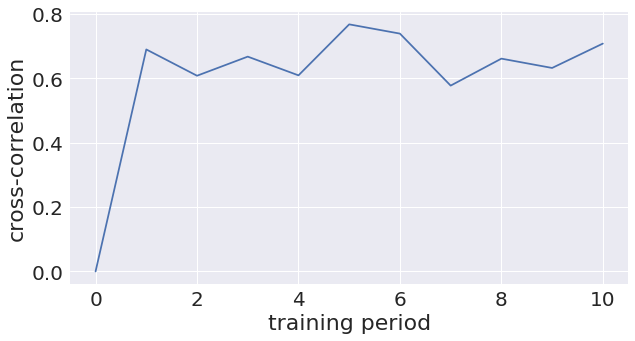

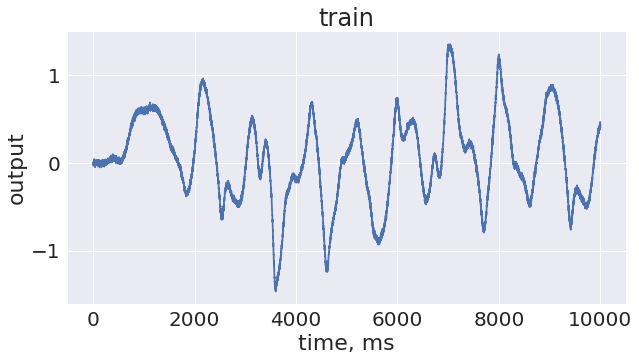

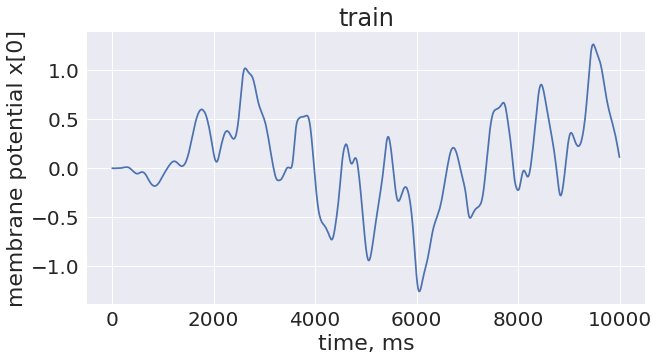

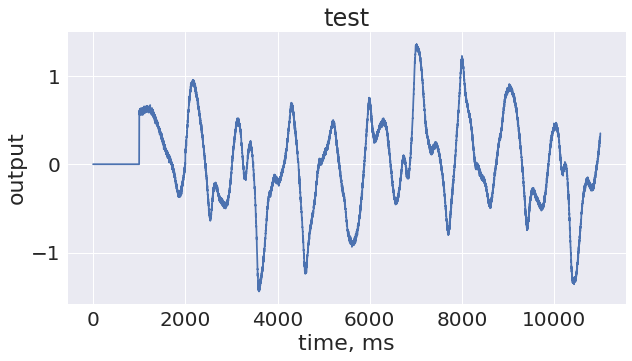

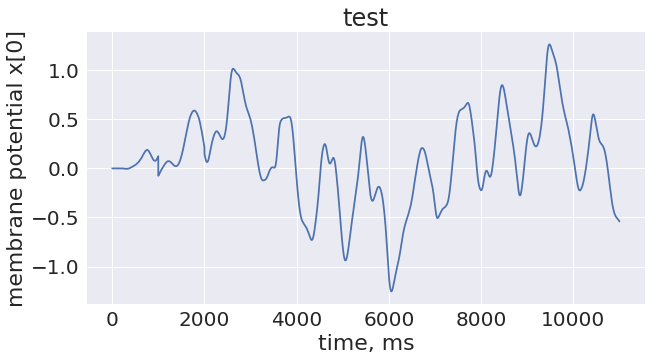

In [9]:
plot(correlation, xlabel='training period', ylabel='cross-correlation')

plot(train_results['z'].flatten(), xlabel='time, ms', ylabel='output', title='train')
plot(train_results['x[0]'].flatten(), xlabel='time, ms', ylabel='membrane potential x[0]', title='train')

plot(test_results['z'].flatten(), xlabel='time, ms', ylabel='output', title='test')
plot(test_results['x[0]'].flatten(), xlabel='time, ms', ylabel='membrane potential x[0]', title='test')